#### **Итоговая позиция в соревновании**  
🏆 **3 место** (с результатом 0.62993 на лидерборде)


- Анна Шестакова
- Алексей Жданов
- Григорий Суханов
- Михаил Футьянов

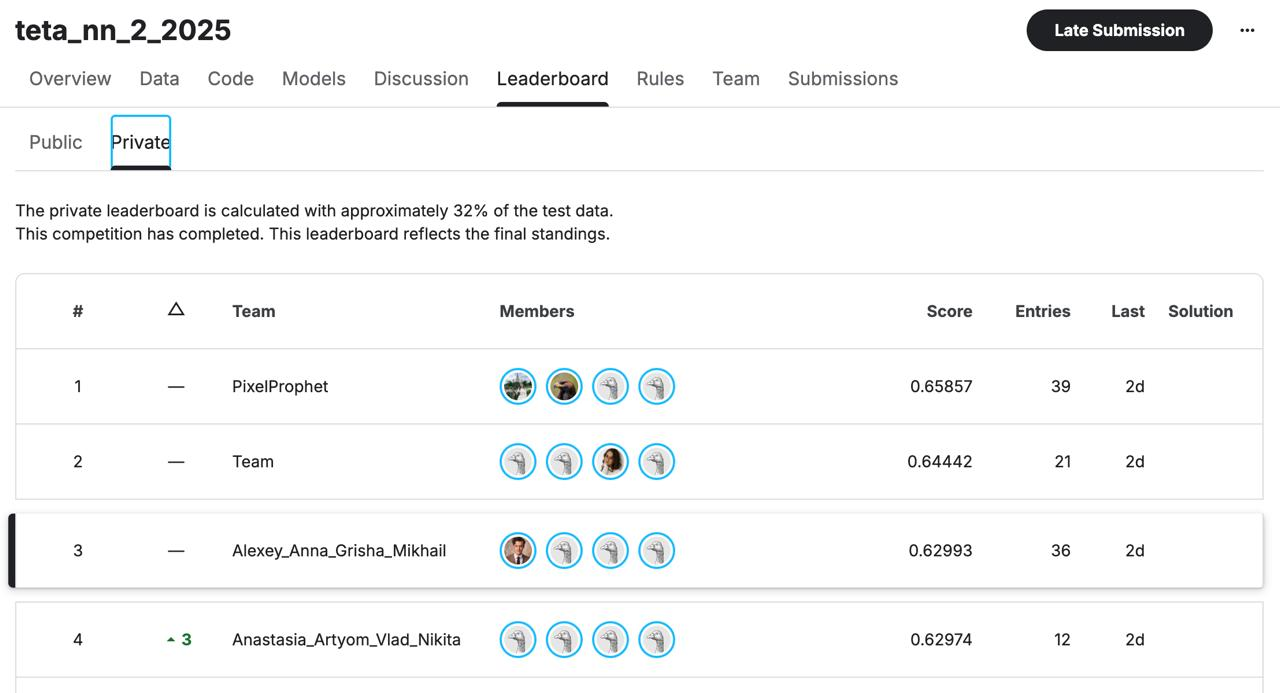



---

### **Intro**  
В данной работе решалась задача бинарной классификации: определение, какое из двух изображений лучше. Такой подход может быть полезен в различных сферах, например:  
- Оценка качества рекламных баннеров.  
- Сравнение дизайнов для A/B-тестирования.  
- Модерация пользовательского контента.  

Основная сложность заключалась в дисбалансе классов (соотношение 65:35) и необходимости эффективного извлечения признаков из изображений.  

---

### **Что пробовали**  

#### **1. Самописная Siamese-сеть на основе UNet-энкодера**  
- **Архитектура**:  
  - Два идентичных энкодера (UNet-like) для извлечения признаков.  
  - Конкатенация признаков и классификация через MLP.  
- **Оптимизация**:  
  - Использовался Optuna для подбора гиперпараметров (глубина, размеры слоёв, dropout).  
  - Лучший результат на валидации: **AUC = 0.571**.  
- **Итог**:  
  - На тесте модель показала **AUC = 0.51122**, что хуже базовых решений.  

#### **2. Fine-tuning предобученных моделей**  
Были протестированы:  
- **ResNet50**:  
  - Заморозка всех слоев, кроме последних блоков.  
  - Лучший AUC на валидации: **0.6322**.  
- **ConvNeXt-Tiny**:  
  - Разморозка последних слоёв.  
  - AUC: **0.6511**, но наблюдалось переобучение.  
- **Swin Transformer**:  
  - Проблемы со сходимостью, AUC: **0.5672**.  

#### **3. Ансамблирование и стекинг**  
- **Стекинг (XGBoost)**:  
  - Объединение предсказаний 4 моделей.  
  - Результат: **0.57666**.  
- **Взвешенный ансамбль**:  
  - Подбор весов через оптимизацию.  
  - Лучший результат: **0.62993**.  

---

### **Что пошло не так?**  

1. **Слабая обобщающая способность самописной модели**:  
   - UNet-энкодер уступает предобученным моделям в извлечении признаков.  
   - Недостаточно данных для обучения с нуля.  

2. **Проблемы с трансформерами (Swin)**:  
   - Модель не смогла адаптироваться к данным, возможно, из-за недостаточной тонкой настройки или особенностей архитектуры.  

3. **Дисбаланс классов**:  
   - Несмотря на взвешивание loss, метрики на минорном классе оставались низкими.  

4. **Переобучение моделей**:  
   - Было сложно подобрать оптимальные гиперпараметры, чтобы избежать переобучения.

---

### **Outro**  
Работа над задачей показала, что:  
✅ **Fine-tuning предобученных моделей** даёт лучшие результаты, чем обучение с нуля.  
✅ **Ансамблирование** может улучшить качество, но требует аккуратной настройки.  



In [ ]:
# Импорты и настройки
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights, resnet50, ResNet50_Weights
from transformers import AutoImageProcessor, AutoModel
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from functools import lru_cache
import random
import time
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import optuna
from optuna.pruners import MedianPruner
import gc
from tqdm import tqdm
import warnings
from scipy.optimize import minimize

In [ ]:
# Для воспроизводимости
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [ ]:
# Гиперпараметры
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10

# Выбор устройства для вычислений
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [ ]:
# Ресурсы

! nvidia-smi

Tue Jul 29 07:08:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:05:00.0 Off |                  N/A |
| 33%   47C    P8             12W /  250W |       4MiB /  22528MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import gc

# Принудительно вызываем сборщик мусора
gc.collect()

# Очищаем кэш CUDA
torch.cuda.empty_cache()

# Загрузка и подготовка данных

In [ ]:
# Загрузка данных
train_path = "/home/sinarian/storage_local/train.parquet"
test_path = "/home/sinarian/storage_local/test.parquet"

train_table = pq.read_table(train_path)
train_df = train_table.to_pandas()
test_table = pq.read_table(test_path)
test_df = test_table.to_pandas()

In [ ]:
print("\nПример данных из обучающего набора (df_train):")
train_df.head(1)


Пример данных из обучающего набора (df_train):


,image_1,image_2,is_image1_better
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'RIFF\x06%\x01\x00WEBPVP8 \xfa$\x01\x00\xb0A\...,1


In [ ]:
print("\nПример данных из тестового набора (df_test):")
test_df.head(1)


Пример данных из тестового набора (df_test):


,image_1,image_2
0,b'RIFFZk\x02\x00WEBPVP8 Nk\x02\x00\x90\xa1\x07...,b'RIFF\xce\xc8\x01\x00WEBPVP8 \xc2\xc8\x01\x00...


Text(0.5, 1.0, 'Распределение меток в train')

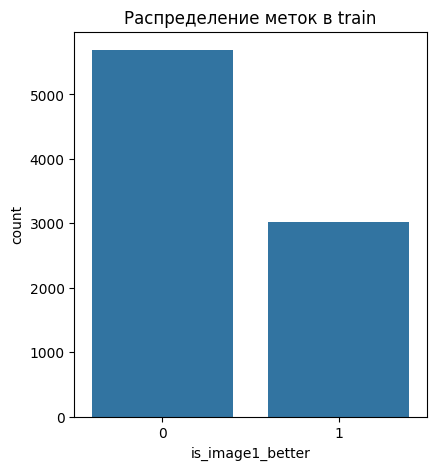

In [ ]:
# Распределение целевой переменной.
import seaborn as sns

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='is_image1_better', data=train_df)
plt.title('Распределение меток в train')

In [ ]:
# Анализ дисбаланса классов
class_ratio = train_df['is_image1_better'].value_counts(normalize=True)
neg, pos = np.bincount(train_data['is_image1_better'])
pos_weight = torch.tensor(neg/pos).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

pos_weight = class_ratio[0] / class_ratio[1]
print(f"\nСоотношение классов:\n{class_ratio}")
print(f"Класс 0 встречается в {class_ratio[0]/class_ratio[1]:.2f} раз чаще")

if max(abs(class_ratio - 0.5)) > 0.1:  # Более строгий порог 10%
    print("\nОбнаружен дисбаланс классов!")
    print(f"pos_weight для loss: {pos_weight:.3f}")


Соотношение классов:
is_image1_better
0    0.653042
1    0.346958
Name: proportion, dtype: float64
Класс 0 встречается в 1.88 раз чаще

Обнаружен дисбаланс классов!
pos_weight для loss: 1.882


In [ ]:
# Разделение на train и val с учетом дисбаланса
train_data, val_holdout = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    stratify=train_df['is_image1_better']
)

print("Train size:", len(train_data))
print("Val size:", len(val_holdout))

Train size: 7403
Val size: 1307


## Датасеты и преобразования

- Быстрой загрузки через кэширование
- Безопасной обработки ошибок
- Применения одинаковых аугментаций к паре изображений

In [ ]:
@lru_cache(maxsize=500)
def _cached_load_image(img_bytes):
    try:
        return Image.open(io.BytesIO(img_bytes)).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return Image.new('RGB', (224, 224))


In [ ]:
class PairTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img1, img2):
        seed = torch.randint(0, 2**32, ()).item()

        # Сохраняем состояния
        random_state = random.getstate()
        np_random_state = np.random.get_state()
        torch_random_state = torch.get_rng_state()

        # Применяем к первому изображению
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        img1_t = self.transform(img1)

        # Восстанавливаем и снова применяем
        random.setstate(random_state)
        np.random.set_state(np_random_state)
        torch.set_rng_state(torch_random_state)

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        img2_t = self.transform(img2)

        return img1_t, img2_t

In [ ]:
class ImagePairDataset(Dataset):
    @staticmethod
    def get_train_transform():
        return transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomApply([transforms.ColorJitter(0.3, 0.3, 0.3, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.1),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    @staticmethod
    def get_val_transform():
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __init__(self, dataframe, transform=None, use_pair_transform=True):
        self.df = dataframe.reset_index(drop=True)
        self.use_pair_transform = use_pair_transform
        self.transform = transform or self.get_val_transform()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            img1 = _cached_load_image(row['image_1']) if isinstance(row['image_1'], (bytes, bytearray)) else row['image_1'].convert('RGB')
            img2 = _cached_load_image(row['image_2']) if isinstance(row['image_2'], (bytes, bytearray)) else row['image_2'].convert('RGB')

            if self.use_pair_transform and 'is_image1_better' in row:
                img1, img2 = PairTransform(self.transform)(img1, img2)
            else:
                img1 = self.transform(img1)
                img2 = self.transform(img2)

            label = torch.tensor(row['is_image1_better'], dtype=torch.float32) if 'is_image1_better' in row else 0.0
            return img1, img2, label

        except Exception as e:
            print(f"Error at idx {idx}: {e}")
            dummy = torch.zeros(3, 224, 224)
            return dummy, dummy, torch.tensor(0.0)

In [ ]:
def create_loader(dataframe, batch_size, is_train=True):
    """
    Создает DataLoader с учетом режима (обучение/валидация)

    Args:
        dataframe (pd.DataFrame): Исходные данные
        batch_size (int): Размер батча
        is_train (bool): Флаг обучения (для аугментаций)

    Returns:
        DataLoader
    """
    transform = ImagePairDataset.get_train_transform() if is_train else ImagePairDataset.get_val_transform()

    dataset = ImagePairDataset(
        dataframe=dataframe,
        transform=transform,
        use_pair_transform=is_train  # Парные аугментации только для обучения
    )

    if is_train:
        # Веса для балансировки классов
        weights = np.where(dataframe['is_image1_better'] == 1, pos_weight, 1.0)
        sampler = WeightedRandomSampler(
            weights=weights,
            num_samples=len(dataframe),
            replacement=True
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=sampler,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        )
    else:
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        )

### Создание датасетов

In [ ]:
# Создание датасетов

train_dataset = ImagePairDataset(train_data, ImagePairDataset.get_train_transform(), True)
val_dataset = ImagePairDataset(val_holdout, ImagePairDataset.get_val_transform(), False)
test_dataset = ImagePairDataset(test_df, ImagePairDataset.get_val_transform(), False)

In [ ]:
# Сэмплер для балансировки классов
sampler = WeightedRandomSampler(
    weights=np.where(train_data['is_image1_better'] == 1, pos_weight, 1.0),
    num_samples=len(train_data),
    replacement=True
)

In [ ]:
# DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


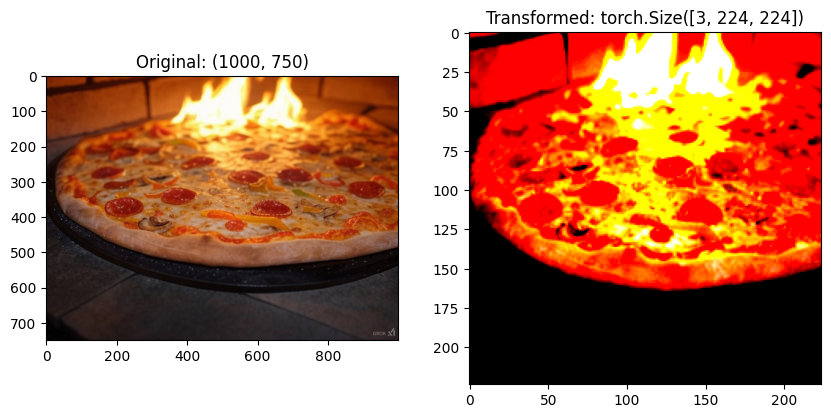

In [ ]:
# Вот так изменилось входное изображение
def show_resize_effect(dataset, idx=0):
    row = dataset.df.iloc[idx]  # Исправлено: .dataframe → .df
    img_original = Image.open(io.BytesIO(row['image_1'])).convert('RGB')
    img_transformed = dataset.transform(img_original)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img_original)
    ax1.set_title(f"Original: {img_original.size}")
    ax2.imshow(img_transformed.permute(1, 2, 0))
    ax2.set_title(f"Transformed: {img_transformed.shape}")
    plt.show()

# Теперь это работает\
show_resize_effect(train_dataset, idx=1)

# Модели

## Функции обучения и валидации

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device):
    """
    Обучение модели на одной эпохе

    Args:
        model (nn.Module): Модель для обучения
        loader (DataLoader): Загрузчик данных
        optimizer: Оптимизатор
        criterion: Функция потерь
        device: Устройство (cuda/cpu)

    Returns:
        tuple: (средний loss, AUC на обучении)
    """
    model.train()
    running_loss = 0.0
    preds = []
    targets = []

    # Убран tqdm
    for img1, img2, labels in loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img1.size(0)
        preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        targets.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_auc = roc_auc_score(targets, preds) if len(set(targets)) > 1 else 0.0
    return epoch_loss, epoch_auc


In [ ]:
def validate(model, loader, criterion, device):
    """
    Валидация модели

    Args:
        model (nn.Module): Модель для валидации
        loader (DataLoader): Загрузчик данных
        criterion: Функция потерь
        device: Устройство (cuda/cpu)

    Returns:
        tuple: (средний loss, AUC на валидации)
    """
    model.eval()
    running_loss = 0.0
    preds = []
    targets = []

    # Убран tqdm
    with torch.no_grad():
        for img1, img2, labels in loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * img1.size(0)
            preds.extend(torch.sigmoid(outputs).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_auc = roc_auc_score(targets, preds) if len(set(targets)) > 1 else 0.0
    return epoch_loss, epoch_auc


In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, val_auc):
        score = -val_loss + val_auc

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
def train_model(model, train_loader, val_loader, model_name, num_epochs=15):
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
    early_stopping = EarlyStopping(patience=5)
    history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

    for epoch in range(num_epochs):
        # Разморозка слоёв
        if epoch == num_epochs // 2 and hasattr(model, 'unfreeze_layers'):
            model.unfreeze_layers()
            print(f"Разморожены слои для {model_name}")

        train_loss, train_auc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_auc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
        print(f"Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}")

        early_stopping(val_loss, val_auc)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return history

In [ ]:
#  Визуализация

def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.legend()

    ax2.plot(history['train_auc'], label='Train AUC')
    ax2.plot(history['val_auc'], label='Val AUC')
    ax2.set_title(f'{model_name} - AUC')
    ax2.legend()

    plt.show()

def plot_roc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

## МОДЕЛЬ 1 : самописная модель

Siamese-сеть написана на основе UNet-энкодера для задачи сравнения изображений.

    Основные принципы:
    Siamese (близнецы): одна и та же сеть обрабатывает оба изображения → сравнивает их в пространстве признаков
    UNet-энкодер: хорошо работает с деталями, имеет иерархическую структуру
    
    Модель будет обучаться с гибкая настройкой через Optuna: подбор depth, fc_size, dropout

Архитектура модели:

```
Вход: (img1, img2) → [B, 3, 224, 224]

1. Каждое изображение проходит через один и тот же UNetEncoder
   │
   ├─ DoubleConv (3 → base_channels) → [B, base_channels, 224, 224]
   ├─ MaxPool + DoubleConv (base_channels → base_channels*2) → [B, base_channels*2, 112, 112]
   ├─ MaxPool + DoubleConv (base_channels*2 → base_channels*4) → [B, base_channels*4, 56, 56]
   ├─ MaxPool + DoubleConv (base_channels*4 → base_channels*8) → [B, base_channels*8, 28, 28]
   └─ AdaptiveAvgPool2d((1,1)) → [B, base_channels*8, 1, 1]

2. Признаки "разворачиваются" в вектор
   feat1 = [B, base_channels*8] = [B, feature_dim]
   feat2 = [B, base_channels*8] = [B, feature_dim]
   (Например, при base_channels=32, depth=3: feature_dim = 32*2^3 = 256)

3. Конкатенация: x = [feat1, feat2] → [B, 2 * feature_dim]

4. Классификатор (MLP):
   Linear(2*feature_dim → fc_size) → ReLU → Dropout →
   Linear(fc_size → fc_size//2) → ReLU → Dropout →
   Linear(fc_size//2 → 1)

Выход: логит (одно число) → сигмоида → вероятность принадлежности к классу 1
```

In [ ]:
# Самописная модель

# Базовый блок: два сверточных слоя с нормализацией и активацией
class DoubleConv(nn.Module):
    """
    Два последовательных сверточных слоя с BatchNorm и GELU.

    - Первый conv: извлекает признаки
    - Второй conv: уточняет признаки
    - BatchNorm: стабилизирует обучение
    - GELU: нелинейность
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True), # Используем inplace для экономии памяти
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


# Энкодер на основе UNet (без декодера)
class UNetEncoder(nn.Module):
    """
    Иерархический энкодер с Global Average Pooling.:
    - Начинает с 3 каналов (RGB)
    - На каждом уровне уменьшает размер в 2 раза, увеличивает каналы в 2 раза

    Параметры:
        base_channels: начальное число каналов (32)
        depth: количество уровней (3)
    """
    def __init__(self, base_channels=32, depth=3):
        super().__init__()
        self.first = DoubleConv(3, base_channels)
        channels = [base_channels]

        for _ in range(depth):
            channels.append(channels[-1] * 2)

        self.downs = nn.ModuleList([
            nn.Sequential(
                nn.MaxPool2d(2),
                DoubleConv(channels[i], channels[i+1])
            ) for i in range(depth)
        ])

        # Добавляем AdaptiveAvgPool2d для уменьшения признаков до [B, C, 1, 1]
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.first(x) # [B, base_channels, H, W]
        for down in self.downs:
            x = down(x)   # [B, C, H', W'] -> ... -> [B, final_channels, H_final, W_final]
        x = self.global_pool(x) # [B, final_channels, 1, 1]
        return x # [B, final_channels, 1, 1]




# Основная Siamese-модель
class HandwrittenSiameseUNet(nn.Module):
    """
    Siamese-сеть для сравнения двух изображений.

    Логика:
    1. Один и тот же энкодер обрабатывает оба изображения
    2. Признаки конкатенируются
    3. Полносвязная сеть принимает решение
    """
    def __init__(self, base_channels=32, depth=3, dropout=0.3, fc_size=256):
        super().__init__()
        self.encoder = UNetEncoder(base_channels=base_channels, depth=depth)

        # feature_dim теперь это количество каналов после энкодера
        # Например, если base_channels=32 и depth=3, то final_channels = 32 * 2^3 = 256
        self.feature_dim = base_channels * (2 ** depth)

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim * 2, fc_size), # Вход: [B, 2 * feature_dim]
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fc_size, fc_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fc_size // 2, 1)
        )

    def forward(self, img1, img2):
        # Получаем признаки размером [B, feature_dim, 1, 1]
        feat1 = self.encoder(img1) # [B, feature_dim, 1, 1]
        feat2 = self.encoder(img2) # [B, feature_dim, 1, 1]

        # Преобразуем в векторы [B, feature_dim]
        feat1 = feat1.view(feat1.size(0), -1) # [B, feature_dim]
        feat2 = feat2.view(feat2.size(0), -1) # [B, feature_dim]

        # Конкатенируем признаки [B, 2 * feature_dim]
        x = torch.cat([feat1, feat2], dim=1) # [B, 2 * feature_dim]

        # Классификация
        return self.classifier(x).squeeze(1) # [B]



#### Визуализация архитектуры
Вывод показывает:

- Размеры тензоров на каждом шаге
- Количество параметров
- Потребление памяти

In [ ]:
from torchsummary import summary

model = HandwrittenSiameseUNet(base_channels=32, depth=3).to(device)
summary(model, [(3, 224, 224), (3, 224, 224)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
        DoubleConv-7         [-1, 32, 224, 224]               0
         MaxPool2d-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]          18,496
      BatchNorm2d-10         [-1, 64, 112, 112]             128
             ReLU-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,928
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

### Оптимизация Optuna для подбора гиперпараметров и 3-CV

In [ ]:
def run_cv(config):
    """
    Выполняет кросс-валидацию для заданной конфигурации.
    Выполняет кросс-валидацию для заданной конфигурации с Early Stopping.
    Возвращает среднее значение AUC по всем фолдам.
    """

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    fold_aucs = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_data["is_image1_better"])):
        print(f"\n=== Fold {fold+1}/3 (Trial {config['trial'].number}) ===")

        train_sub = train_data.iloc[train_idx].reset_index(drop=True)
        val_sub = train_data.iloc[val_idx].reset_index(drop=True)

        # Датасеты и загрузчики (убедитесь, что ImagePairDataset определен)
        train_dataset = ImagePairDataset(train_sub, ImagePairDataset.get_train_transform())
        val_dataset = ImagePairDataset(val_sub, ImagePairDataset.get_val_transform(), use_pair_transform=False)

        # Балансировка классов
        neg, pos = np.bincount(train_sub["is_image1_better"])
        pos_weight = neg / pos
        sampler = WeightedRandomSampler(
            weights=np.where(train_sub["is_image1_better"] == 1, pos_weight, 1.0),
            num_samples=len(train_sub),
            replacement=True
        )

        train_dl = DataLoader(
            train_dataset,
            batch_size=config["batch_size"],
            sampler=sampler,
            num_workers=2, # Можно увеличить, если есть ресурсы
            pin_memory=True
        )
        val_dl = DataLoader(
            val_dataset,
            batch_size=config["batch_size"],
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        # Модель и оптимизатор
        # Передаем только параметры, относящиеся к модели
        model_params = {k: v for k, v in config.items() if k in ["base_channels", "depth", "dropout", "fc_size"]}
        model = HandwrittenSiameseUNet(**model_params).to(device)

        optimizer = AdamW(
            model.parameters(),
            lr=config["lr"],
            weight_decay=config["weight_decay"]
        )
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=device))

        # --- Early Stopping ---
        best_auc = 0.0
        patience = 3 # Количество эпох без улучшения до остановки
        patience_counter = 0

        # Цикл обучения
        for epoch in range(config["epochs"]):
            train_loss, train_auc = train_epoch(model, train_dl, optimizer, criterion, device)
            val_loss, val_auc = validate(model, val_dl, criterion, device)

            print(f"Epoch {epoch+1}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}")

            # --- Optuna Pruning ---
            config["trial"].report(val_auc, epoch)
            if config["trial"].should_prune():
                print(f"🛑 Trial {config['trial'].number} pruned at epoch {epoch+1}")
                # Очищаем память перед прерыванием
                del model, optimizer, criterion
                torch.cuda.empty_cache()
                gc.collect()
                raise optuna.TrialPruned()

            # --- Early Stopping Logic ---
            if val_auc > best_auc:
                best_auc = val_auc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break # Выходим из цикла по эпохам для этого фолда

        print(f"Fold {fold+1} best AUC: {best_auc:.4f}")
        fold_aucs.append(best_auc)

        # Очищаем память после фолда
        del model, optimizer, criterion
        torch.cuda.empty_cache()
        gc.collect()

    return np.mean(fold_aucs)

In [ ]:
def objective(trial):
    """
    Целевая функция для Optuna.
    """
    config = {
        "trial": trial,
        "base_channels": trial.suggest_categorical("base_channels", [32, 64, 128]),
        "depth": trial.suggest_int("depth", 2, 3),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5),
        "fc_size": trial.suggest_categorical("fc_size", [64, 128, 256]),
        "lr": trial.suggest_float("lr", 1e-5, 1e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True),
        "epochs": 20, # Фиксированное максимальное количество эпох
    }

    try:
        return run_cv(config)
    except optuna.TrialPruned:
        # Не выводим ошибку — TrialPruned — это норма
        raise
    except Exception as e:
        print(f"Trial {trial.number} failed with an unexpected error: {e}")
        # Очищаем память при неожиданной ошибке
        torch.cuda.empty_cache()
        gc.collect()
        raise optuna.TrialPruned() # Прерываем trial


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

study = optuna.create_study(
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=3,  # Первые 3 trial не прерываются
            n_warmup_steps=2,    # Первые 2 эпохи каждого trial не учитываются
            interval_steps=2     # Проверяем каждые 2 эпохи после warmup
        ))

print("Starting optimization...")
study.optimize(objective, n_trials=10, gc_after_trial=True)

# Результаты
print("\n" + "="*50)
print("✅ ЛУЧШИЙ TRIAL НАЙДЕН")
print(f"Best trial: {study.best_trial.number}")
print(f"Best AUC: {study.best_value:.4f}")
print("Best parameters:")
for k, v in study.best_trial.params.items():
    print(f"  {k}: {v}")
print("="*50)


[I 2025-07-29 07:08:39,850] A new study created in memory with name: no-name-0e6465e4-582f-4be0-826f-c4178864ae1f


Starting optimization...

=== Fold 1/3 (Trial 0) ===
Epoch 1: Train AUC=0.4898, Val AUC=0.4960
Epoch 2: Train AUC=0.5056, Val AUC=0.5341
Epoch 3: Train AUC=0.5167, Val AUC=0.5545
Epoch 4: Train AUC=0.5181, Val AUC=0.5439
Epoch 5: Train AUC=0.5094, Val AUC=0.5457
Epoch 6: Train AUC=0.5086, Val AUC=0.5120
Early stopping triggered at epoch 6
Fold 1 best AUC: 0.5545

=== Fold 2/3 (Trial 0) ===
Epoch 1: Train AUC=0.5357, Val AUC=0.5177
Epoch 2: Train AUC=0.5077, Val AUC=0.5093
Epoch 3: Train AUC=0.5258, Val AUC=0.5280
Epoch 4: Train AUC=0.5236, Val AUC=0.5201
Epoch 5: Train AUC=0.5399, Val AUC=0.5327
Epoch 6: Train AUC=0.5355, Val AUC=0.5352
Epoch 7: Train AUC=0.5439, Val AUC=0.5222
Epoch 8: Train AUC=0.5267, Val AUC=0.5203
Epoch 9: Train AUC=0.5345, Val AUC=0.5350
Early stopping triggered at epoch 9
Fold 2 best AUC: 0.5352

=== Fold 3/3 (Trial 0) ===
Epoch 1: Train AUC=0.5128, Val AUC=0.5219
Epoch 2: Train AUC=0.5259, Val AUC=0.5368
Epoch 3: Train AUC=0.5240, Val AUC=0.5367
Epoch 4: Train 

[I 2025-07-29 07:52:23,287] Trial 0 finished with value: 0.5448590858444566 and parameters: {'base_channels': 64, 'depth': 3, 'dropout': 0.1224000406663488, 'fc_size': 64, 'lr': 0.0007266835467181303, 'batch_size': 32, 'weight_decay': 0.0003368318075447994}. Best is trial 0 with value: 0.5448590858444566.


Epoch 8: Train AUC=0.5287, Val AUC=0.5300
Early stopping triggered at epoch 8
Fold 3 best AUC: 0.5449

=== Fold 1/3 (Trial 1) ===
Epoch 1: Train AUC=0.5033, Val AUC=0.5563
Epoch 2: Train AUC=0.5305, Val AUC=0.5646
Epoch 3: Train AUC=0.5365, Val AUC=0.5606
Epoch 4: Train AUC=0.5243, Val AUC=0.5710
Epoch 5: Train AUC=0.5479, Val AUC=0.5639
Epoch 6: Train AUC=0.5492, Val AUC=0.5717
Epoch 7: Train AUC=0.5406, Val AUC=0.5706
Epoch 8: Train AUC=0.5567, Val AUC=0.5669
Epoch 9: Train AUC=0.5376, Val AUC=0.5791
Epoch 10: Train AUC=0.5465, Val AUC=0.5693
Epoch 11: Train AUC=0.5431, Val AUC=0.5729
Epoch 12: Train AUC=0.5430, Val AUC=0.5769
Early stopping triggered at epoch 12
Fold 1 best AUC: 0.5791

=== Fold 2/3 (Trial 1) ===
Epoch 1: Train AUC=0.5221, Val AUC=0.5349
Epoch 2: Train AUC=0.5495, Val AUC=0.5489
Epoch 3: Train AUC=0.5355, Val AUC=0.5460
Epoch 4: Train AUC=0.5513, Val AUC=0.5334
Epoch 5: Train AUC=0.5394, Val AUC=0.5457
Early stopping triggered at epoch 5
Fold 2 best AUC: 0.5489

===

[I 2025-07-29 08:35:36,934] Trial 1 finished with value: 0.5618259763581176 and parameters: {'base_channels': 32, 'depth': 2, 'dropout': 0.2795951927864573, 'fc_size': 64, 'lr': 0.00015942512653963932, 'batch_size': 16, 'weight_decay': 0.0003853085415285673}. Best is trial 1 with value: 0.5618259763581176.


Epoch 6: Train AUC=0.5511, Val AUC=0.5549
Early stopping triggered at epoch 6
Fold 3 best AUC: 0.5575

=== Fold 1/3 (Trial 2) ===
Epoch 1: Train AUC=0.5095, Val AUC=0.4746
Epoch 2: Train AUC=0.5295, Val AUC=0.5505
Epoch 3: Train AUC=0.5284, Val AUC=0.5389
Epoch 4: Train AUC=0.5498, Val AUC=0.5570
Epoch 5: Train AUC=0.5339, Val AUC=0.5581
Epoch 6: Train AUC=0.5550, Val AUC=0.5732
Epoch 7: Train AUC=0.5461, Val AUC=0.5672
Epoch 8: Train AUC=0.5572, Val AUC=0.5702
Epoch 9: Train AUC=0.5340, Val AUC=0.5593
Early stopping triggered at epoch 9
Fold 1 best AUC: 0.5732

=== Fold 2/3 (Trial 2) ===
Epoch 1: Train AUC=0.5268, Val AUC=0.5279
Epoch 2: Train AUC=0.5149, Val AUC=0.5377
Epoch 3: Train AUC=0.5439, Val AUC=0.5357
Epoch 4: Train AUC=0.5251, Val AUC=0.5437
Epoch 5: Train AUC=0.5261, Val AUC=0.5413
Epoch 6: Train AUC=0.5448, Val AUC=0.5387
Epoch 8: Train AUC=0.5355, Val AUC=0.5392
Epoch 9: Train AUC=0.5553, Val AUC=0.5472
Epoch 10: Train AUC=0.5476, Val AUC=0.5585
Epoch 11: Train AUC=0.550

[I 2025-07-29 09:33:55,420] Trial 2 finished with value: 0.5615374278158677 and parameters: {'base_channels': 32, 'depth': 3, 'dropout': 0.2526161634446006, 'fc_size': 256, 'lr': 0.0001828702542978105, 'batch_size': 16, 'weight_decay': 0.00016656577352109752}. Best is trial 1 with value: 0.5618259763581176.


Epoch 8: Train AUC=0.5442, Val AUC=0.5357
Early stopping triggered at epoch 8
Fold 3 best AUC: 0.5471

=== Fold 1/3 (Trial 3) ===
Epoch 1: Train AUC=0.5166, Val AUC=0.5551
Epoch 2: Train AUC=0.5421, Val AUC=0.5635
Epoch 3: Train AUC=0.5407, Val AUC=0.5684
Epoch 4: Train AUC=0.5415, Val AUC=0.5683
Epoch 5: Train AUC=0.5535, Val AUC=0.5730
Epoch 6: Train AUC=0.5384, Val AUC=0.5710
Epoch 7: Train AUC=0.5564, Val AUC=0.5758
Epoch 8: Train AUC=0.5584, Val AUC=0.5710
Epoch 9: Train AUC=0.5643, Val AUC=0.5677
Epoch 10: Train AUC=0.5504, Val AUC=0.5836
Epoch 11: Train AUC=0.5644, Val AUC=0.5811
Epoch 12: Train AUC=0.5594, Val AUC=0.5834
Epoch 13: Train AUC=0.5681, Val AUC=0.5698
Early stopping triggered at epoch 13
Fold 1 best AUC: 0.5836

=== Fold 2/3 (Trial 3) ===
Epoch 1: Train AUC=0.5272, Val AUC=0.5365
Epoch 2: Train AUC=0.5439, Val AUC=0.5609
Epoch 3: Train AUC=0.5578, Val AUC=0.5561
Epoch 4: Train AUC=0.5631, Val AUC=0.5518
Epoch 5: Train AUC=0.5773, Val AUC=0.5492
Early stopping trigge

[I 2025-07-29 10:28:43,187] Trial 3 finished with value: 0.570993803098083 and parameters: {'base_channels': 64, 'depth': 2, 'dropout': 0.2510318180876234, 'fc_size': 128, 'lr': 4.690728289527105e-05, 'batch_size': 16, 'weight_decay': 0.0006517145070628878}. Best is trial 3 with value: 0.570993803098083.


Epoch 11: Train AUC=0.5687, Val AUC=0.5583
Early stopping triggered at epoch 11
Fold 3 best AUC: 0.5684

=== Fold 1/3 (Trial 4) ===
Epoch 1: Train AUC=0.5170, Val AUC=0.5726
Epoch 2: Train AUC=0.5449, Val AUC=0.5648
Epoch 3: Train AUC=0.5564, Val AUC=0.5627
Epoch 4: Train AUC=0.5628, Val AUC=0.5699
Early stopping triggered at epoch 4
Fold 1 best AUC: 0.5726

=== Fold 2/3 (Trial 4) ===
Epoch 1: Train AUC=0.5156, Val AUC=0.5410
Epoch 2: Train AUC=0.5429, Val AUC=0.5473
Epoch 3: Train AUC=0.5563, Val AUC=0.5493
Epoch 4: Train AUC=0.5617, Val AUC=0.5485
Epoch 5: Train AUC=0.5573, Val AUC=0.5508
Epoch 6: Train AUC=0.5661, Val AUC=0.5469
Epoch 7: Train AUC=0.5798, Val AUC=0.5579
Epoch 8: Train AUC=0.5686, Val AUC=0.5578
Epoch 9: Train AUC=0.5626, Val AUC=0.5491
Epoch 10: Train AUC=0.5673, Val AUC=0.5510
Early stopping triggered at epoch 10
Fold 2 best AUC: 0.5579

=== Fold 3/3 (Trial 4) ===
Epoch 1: Train AUC=0.5252, Val AUC=0.5455
Epoch 2: Train AUC=0.5445, Val AUC=0.5519
Epoch 3: Train AUC

[I 2025-07-29 11:08:30,407] Trial 4 finished with value: 0.5645258485047552 and parameters: {'base_channels': 64, 'depth': 2, 'dropout': 0.2373791768182919, 'fc_size': 256, 'lr': 1.966230119579112e-05, 'batch_size': 32, 'weight_decay': 1.9407989707051477e-06}. Best is trial 3 with value: 0.570993803098083.


Epoch 7: Train AUC=0.5708, Val AUC=0.5559
Early stopping triggered at epoch 7
Fold 3 best AUC: 0.5630

=== Fold 1/3 (Trial 5) ===
Epoch 1: Train AUC=0.5107, Val AUC=0.5568
Epoch 2: Train AUC=0.5302, Val AUC=0.5692
Epoch 3: Train AUC=0.5452, Val AUC=0.5744
Epoch 4: Train AUC=0.5566, Val AUC=0.5720
Epoch 5: Train AUC=0.5518, Val AUC=0.5717
Epoch 6: Train AUC=0.5616, Val AUC=0.5737
Early stopping triggered at epoch 6
Fold 1 best AUC: 0.5744

=== Fold 2/3 (Trial 5) ===
Epoch 1: Train AUC=0.5120, Val AUC=0.5360
Epoch 2: Train AUC=0.5507, Val AUC=0.5479
Epoch 3: Train AUC=0.5541, Val AUC=0.5556
Epoch 4: Train AUC=0.5644, Val AUC=0.5547
Epoch 5: Train AUC=0.5761, Val AUC=0.5534
Epoch 6: Train AUC=0.5621, Val AUC=0.5504
Early stopping triggered at epoch 6
Fold 2 best AUC: 0.5556

=== Fold 3/3 (Trial 5) ===
Epoch 1: Train AUC=0.5064, Val AUC=0.5368
Epoch 2: Train AUC=0.5268, Val AUC=0.5499
Epoch 3: Train AUC=0.5447, Val AUC=0.5538
Epoch 4: Train AUC=0.5725, Val AUC=0.5510
Epoch 5: Train AUC=0.5

[I 2025-07-29 11:52:12,184] Trial 5 finished with value: 0.5661191653192629 and parameters: {'base_channels': 64, 'depth': 2, 'dropout': 0.3037664844118618, 'fc_size': 256, 'lr': 1.5896246712171195e-05, 'batch_size': 32, 'weight_decay': 0.00057844448511874}. Best is trial 3 with value: 0.570993803098083.


Epoch 11: Train AUC=0.5767, Val AUC=0.5644
Early stopping triggered at epoch 11
Fold 3 best AUC: 0.5683

=== Fold 1/3 (Trial 6) ===
Epoch 1: Train AUC=0.5293, Val AUC=0.5359
Epoch 2: Train AUC=0.5403, Val AUC=0.5544
Epoch 3: Train AUC=0.5164, Val AUC=0.5648


[I 2025-07-29 12:03:10,773] Trial 6 pruned. 


Epoch 4: Train AUC=0.5392, Val AUC=0.5172
🛑 Trial 6 pruned at epoch 4

=== Fold 1/3 (Trial 7) ===
Epoch 1: Train AUC=0.5360, Val AUC=0.5288
Epoch 2: Train AUC=0.5128, Val AUC=0.5532
Epoch 3: Train AUC=0.5400, Val AUC=0.5640


[I 2025-07-29 12:10:45,661] Trial 7 pruned. 


Epoch 4: Train AUC=0.5469, Val AUC=0.5663
🛑 Trial 7 pruned at epoch 4

=== Fold 1/3 (Trial 8) ===
Epoch 1: Train AUC=0.5214, Val AUC=0.5648
Epoch 2: Train AUC=0.5190, Val AUC=0.5688
Epoch 3: Train AUC=0.5303, Val AUC=0.5496


[I 2025-07-29 12:20:36,407] Trial 8 pruned. 


Epoch 4: Train AUC=0.5171, Val AUC=0.5582
🛑 Trial 8 pruned at epoch 4

=== Fold 1/3 (Trial 9) ===
Epoch 1: Train AUC=0.5101, Val AUC=0.5689
Epoch 2: Train AUC=0.5349, Val AUC=0.5641
Epoch 3: Train AUC=0.5366, Val AUC=0.5741
Epoch 4: Train AUC=0.5440, Val AUC=0.5785
Epoch 5: Train AUC=0.5428, Val AUC=0.5685
Epoch 6: Train AUC=0.5546, Val AUC=0.5747
Epoch 7: Train AUC=0.5563, Val AUC=0.5600
Early stopping triggered at epoch 7
Fold 1 best AUC: 0.5785

=== Fold 2/3 (Trial 9) ===
Epoch 1: Train AUC=0.5304, Val AUC=0.5376
Epoch 2: Train AUC=0.5532, Val AUC=0.5514
Epoch 3: Train AUC=0.5654, Val AUC=0.5524
Epoch 4: Train AUC=0.5750, Val AUC=0.5633
Epoch 5: Train AUC=0.5788, Val AUC=0.5633
Epoch 6: Train AUC=0.5587, Val AUC=0.5584
Epoch 7: Train AUC=0.5624, Val AUC=0.5554
Epoch 8: Train AUC=0.5730, Val AUC=0.5528
Early stopping triggered at epoch 8
Fold 2 best AUC: 0.5633

=== Fold 3/3 (Trial 9) ===
Epoch 1: Train AUC=0.5312, Val AUC=0.5453
Epoch 2: Train AUC=0.5399, Val AUC=0.5459
Epoch 3: Tra

[I 2025-07-29 13:13:51,729] Trial 9 finished with value: 0.5686195356926734 and parameters: {'base_channels': 128, 'depth': 2, 'dropout': 0.22238663490264554, 'fc_size': 64, 'lr': 3.3868528795763506e-05, 'batch_size': 32, 'weight_decay': 0.00039009226990791837}. Best is trial 3 with value: 0.570993803098083.


Epoch 7: Train AUC=0.5515, Val AUC=0.5565
Early stopping triggered at epoch 7
Fold 3 best AUC: 0.5641

✅ ЛУЧШИЙ TRIAL НАЙДЕН
Best trial: 3
Best AUC: 0.5710
Best parameters:
  base_channels: 64
  depth: 2
  dropout: 0.2510318180876234
  fc_size: 128
  lr: 4.690728289527105e-05
  batch_size: 16
  weight_decay: 0.0006517145070628878


На самом деле, если бы не было ранней остановки, он бы дошел до 0.59

### Обучение финальной самописной модели с лучшими параметрами с валидацией на отложенной выборке

In [ ]:
best_params = study.best_trial.params

# {'base_channels': 64,
#  'depth': 2,
#  'dropout': 0.2510318180876234,
#  'fc_size': 128,
#  'lr': 4.690728289527105e-05,
#  'batch_size': 16,
#  'weight_decay': 0.0006517145070628878}

Epoch 1: Train Loss=0.9314, Val Loss=0.9623
Train AUC=0.5383, Val AUC=0.5710
Epoch 2: Train Loss=0.9283, Val Loss=0.9499
Train AUC=0.5414, Val AUC=0.5706
Epoch 3: Train Loss=0.9249, Val Loss=1.0049
Train AUC=0.5538, Val AUC=0.5560
Epoch 4: Train Loss=0.9230, Val Loss=0.9739
Train AUC=0.5582, Val AUC=0.5666
Epoch 5: Train Loss=0.9235, Val Loss=0.9662
Train AUC=0.5575, Val AUC=0.5853
Epoch 6: Train Loss=0.9210, Val Loss=0.9832
Train AUC=0.5654, Val AUC=0.5596
Epoch 7: Train Loss=0.9225, Val Loss=1.0051
Train AUC=0.5580, Val AUC=0.5505
Early stopping triggered.


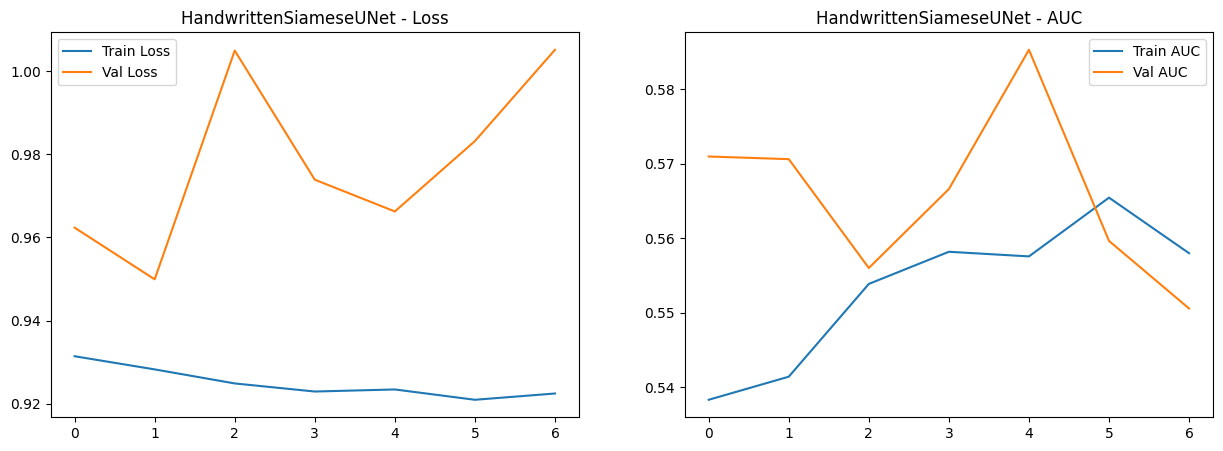

✅ Обучение финальной модели завершено.


In [ ]:
# Инициализация модели с лучшими параметрами
final_hand_model = HandwrittenSiameseUNet(
    base_channels=best_params["base_channels"],
    depth=best_params["depth"],
    dropout=best_params["dropout"],
    fc_size=best_params["fc_size"]
).to(device)

# Оптимизатор с лучшими параметрами
optimizer = AdamW(
    final_hand_model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

# Функция потерь
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))

# Полный цикл обучения с ранней остановкой
early_stopping = EarlyStopping(patience=5)
history = {"train_loss": [], "val_loss": [], "train_auc": [], "val_auc": []} # Исправлены ключи

for epoch in range(30):
    train_loss, train_auc = train_epoch(final_hand_model, train_loader, optimizer, criterion, device)
    val_loss, val_auc = validate(final_hand_model, val_loader, criterion, device)

    # Исправлены ключи
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_auc"].append(train_auc)
    history["val_auc"].append(val_auc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")
    print(f"Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}")

    early_stopping(val_loss, val_auc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

# Визуализация
plot_history(history, "HandwrittenSiameseUNet")
print("✅ Обучение финальной модели завершено.")

In [ ]:
print("\n🔍 Подбор оптимального порога на валидационном наборе...")

# Получаем предсказания (вероятности) на валидационном наборе
final_hand_model.eval() # Убедимся, что модель в режиме оценки
val_predictions_probs = []
val_true_labels = []

with torch.no_grad():
    for img1, img2, labels in val_loader: # Используем val_loader
        img1, img2 = img1.to(device), img2.to(device)
        outputs = final_hand_model(img1, img2)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        val_predictions_probs.extend(probabilities)
        # Собираем истинные метки из val_loader
        val_true_labels.extend(labels.numpy())

val_predictions_probs = np.array(val_predictions_probs)
val_true_labels = np.array(val_true_labels)

print(f"✅ Получено {len(val_predictions_probs)} предсказаний на валидации.")


🔍 Подбор оптимального порога на валидационном наборе...
✅ Получено 1307 предсказаний на валидации.


Переберём различные пороги и выберем лучший:
Порог будем определять по F1-score, так как ROC AUC уже рассчитан на валидации (0.57), и он не зависит от порога, поэтому мы будем использовать другую метрику, зависящую от порога.

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# 2. Подбор порога
thresholds = np.arange(0.1, 1.0, 0.01) # Проверяем пороги от 0.1 до 0.99 с шагом 0.01
f1_scores = []
acc_scores = []

for thresh in thresholds:
    # Преобразуем вероятности в бинарные предсказания
    val_predictions_binary = (val_predictions_probs > thresh).astype(int)
    # Вычисляем метрики
    f1 = f1_score(val_true_labels, val_predictions_binary)
    acc = accuracy_score(val_true_labels, val_predictions_binary)
    f1_scores.append(f1)
    acc_scores.append(acc)

# Находим лучший порог по F1-score
best_f1_index = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

# Можно также найти лучший порог по Accuracy
best_acc_index = np.argmax(acc_scores)
best_threshold_acc = thresholds[best_acc_index]
best_acc_score = acc_scores[best_acc_index]

print(f"📊 Результаты подбора порога на валидационном наборе:")
print(f"   - Лучший порог по F1-score: {best_threshold_f1:.4f} (F1 = {best_f1_score:.4f})")
print(f"   - Лучший порог по Accuracy: {best_threshold_acc:.4f} (Acc = {best_acc_score:.4f})")

# Выберем один порог для использования (например, по F1)
optimal_threshold = best_threshold_f1
print(f"✅ Оптимальный порог выбран: {optimal_threshold:.4f} (максимизирует F1-score)")

📊 Результаты подбора порога на валидационном наборе:
   - Лучший порог по F1-score: 0.5800 (F1 = 0.5194)
   - Лучший порог по Accuracy: 0.8500 (Acc = 0.6557)
✅ Оптимальный порог выбран: 0.5800 (максимизирует F1-score)


### Промежуточный инференс самописной модели:

In [ ]:
final_hand_model.eval() # режим оценки

# Список для хранения предсказаний
test_predictions_HandwrittenSiameseUNet = []

# Отключаем градиенты для экономии памяти и ускорения
with torch.no_grad():
    # Итерируемся по тестовому DataLoader'у
    for img1, img2, _ in test_loader: # _ потому что метки отсутствуют
        # Переносим изображения на устройство (GPU/CPU)
        img1 = img1.to(device)
        img2 = img2.to(device)

        # Получаем выход модели (логиты)
        outputs = final_hand_model(img1, img2)

        # Применяем сигмоиду для получения вероятностей
        probabilities = torch.sigmoid(outputs).cpu().numpy()

        # Добавляем предсказания в список
        test_predictions_HandwrittenSiameseUNet.extend(probabilities)

# Преобразуем список в NumPy массив для удобства
test_predictions_HandwrittenSiameseUNet = np.array(test_predictions_HandwrittenSiameseUNet)

# Сохраняем результаты
submit_df = pd.DataFrame({
    'index': range(len(test_predictions_HandwrittenSiameseUNet)),
    'is_image1_better': (test_predictions_HandwrittenSiameseUNet > optimal_threshold).astype(int) # пока порог 0.5
})

submit_df.to_csv("final_hand_model.csv", index=False)
print("✅ Предсказания сохранены в 'final_hand_model.csv' ")

✅ Предсказания сохранены в 'final_hand_model.csv' 


Результат оптимизированной самописной модели : 0.51122

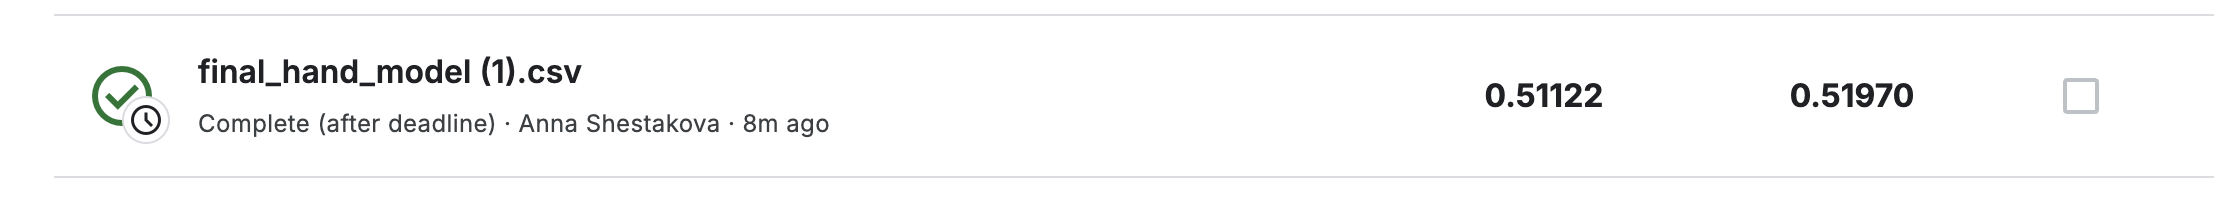

Далее будем проводить fine-tuning предобученных моделей

## Модель 2: Улучшенная ResNet50

In [ ]:
# 1. архитектура fintuning ResNet50

class ImprovedSiameseResNet(nn.Module):
    def __init__(self, freeze_encoder=True):
        super().__init__()

        # 1. Загрузка предобученной ResNet50
        self.encoder = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()  # Удаляем последний слой

        # 2. Закрепление весов (замораживаем всё кроме layer3 и layer4)
        if freeze_encoder:
            self._freeze_encoder()

        # 3. Улучшенный классификатор с регуляризацией
        self.classifier = nn.Sequential(
            nn.Linear(num_features * 2, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.5),  # Увеличенный dropout
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),  # Добавлен новый слой
            nn.SiLU(),
            nn.Linear(128, 1)
        )
        # 4. Инициализация весов
        self._init_weights()

    def _init_weights(self):
        """Инициализация весов классификатора"""
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def _freeze_encoder(self):
        """Заморозка всех слоев, кроме последних двух блоков"""
        for name, param in self.encoder.named_parameters():
            if 'layer3' not in name and 'layer4' not in name:
                param.requires_grad = False
        print("Заморожены все слои кроме layer3 и layer4")

    def unfreeze_layers(self, epoch):
        """Контролируемое размораживание по эпохам"""
        if epoch == 2:
            for name, param in self.encoder.named_parameters():
                if 'layer2' in name:
                    param.requires_grad = True
            print("Разморожен layer2")
        elif epoch == 4:
            for name, param in self.encoder.named_parameters():
                if 'layer1' in name:
                    param.requires_grad = True
            print("Разморожен layer1")

    def forward(self, img1, img2):
        """Прямой проход через сиамскую сеть"""
        feat1 = self.encoder(img1)
        feat2 = self.encoder(img2)
        x = torch.cat([feat1, feat2], dim=1)
        return self.classifier(x).squeeze(1)

In [ ]:
# 2. Обучаем ResNet50
def train_resnet(train_loader, val_loader, device, num_epochs=12):
    """Оптимизированная функция обучения"""
    model = ImprovedSiameseResNet().to(device)

    # 1. Настроенный оптимизатор
    optimizer = AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=2e-5,
        weight_decay=0.01
    )

    # 2. Scheduler с warmup
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=3e-5,
        total_steps=num_epochs * len(train_loader),
        pct_start=0.1
    )

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
    early_stopping = EarlyStopping(patience=4)
    history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

    for epoch in range(num_epochs):
        # 3. Контролируемое размораживание
        model.unfreeze_layers(epoch)

        # Обучение
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []
        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Валидация
        val_loss, val_preds, val_targets = 0.0, [], []
        model.eval()
        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                outputs = model(img1, img2)
                val_loss += criterion(outputs, labels).item()
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Метрики
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_auc = roc_auc_score(train_targets, train_preds)
        val_auc = roc_auc_score(val_targets, val_preds)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        if early_stopping(val_loss, val_auc):
            print("Early stopping")
            break

    return model, history


=== Training ResNet50 ===
Заморожены все слои кроме layer3 и layer4
Epoch 1/12
Train Loss: 7.0390 | Val Loss: 3.3623
Train AUC: 0.5211 | Val AUC: 0.5761
LR: 2.81e-05
Epoch 2/12
Train Loss: 5.4595 | Val Loss: 3.1463
Train AUC: 0.5657 | Val AUC: 0.6062
LR: 2.96e-05
Разморожен layer2
Epoch 3/12
Train Loss: 4.6269 | Val Loss: 2.8091
Train AUC: 0.5912 | Val AUC: 0.6037
LR: 2.80e-05
Epoch 4/12
Train Loss: 4.2394 | Val Loss: 2.6858
Train AUC: 0.5925 | Val AUC: 0.6140
LR: 2.53e-05
Разморожен layer1
Epoch 5/12
Train Loss: 3.7147 | Val Loss: 2.4145
Train AUC: 0.6125 | Val AUC: 0.6318
LR: 2.17e-05
Epoch 6/12
Train Loss: 3.6525 | Val Loss: 2.5628
Train AUC: 0.6006 | Val AUC: 0.6322
LR: 1.76e-05
Epoch 7/12
Train Loss: 3.2642 | Val Loss: 2.3169
Train AUC: 0.6141 | Val AUC: 0.6246
LR: 1.32e-05
Epoch 8/12
Train Loss: 3.2914 | Val Loss: 2.2334
Train AUC: 0.6039 | Val AUC: 0.6208
LR: 9.05e-06
Epoch 9/12
Train Loss: 3.1573 | Val Loss: 2.5001
Train AUC: 0.6168 | Val AUC: 0.6224
LR: 5.35e-06
Epoch 10/12
T

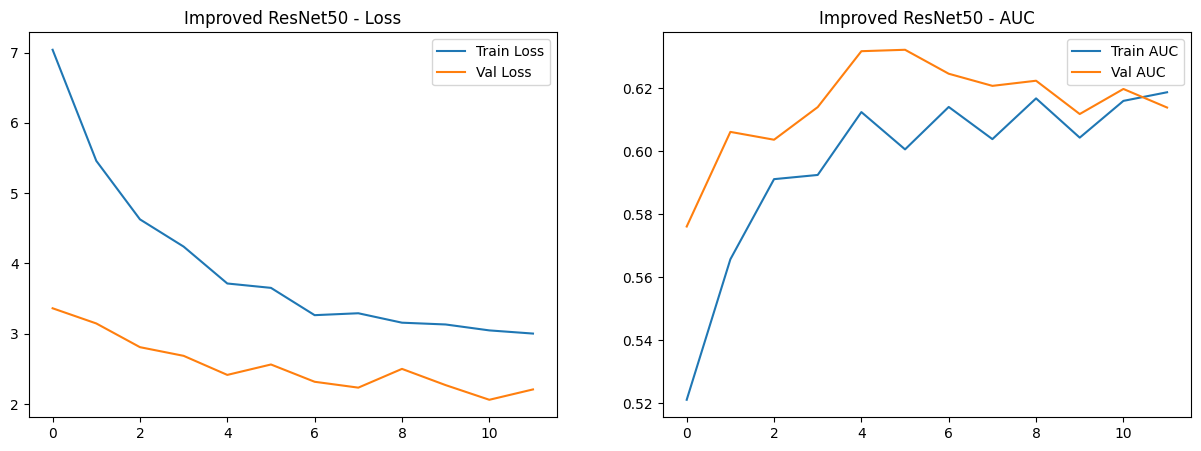

In [ ]:
# 1. Обучаем ResNet50
print("\n=== Training ResNet50 ===")
model, history = train_resnet(train_loader, val_loader, device)
plot_history(history, "Improved ResNet50")

На данной модели практически удалось преодолеть переобучение.

## Модель 3: ConvNeXt-Tiny

In [ ]:
# 1. архитектура fintuning ConvNeXt
class SiameseConvNeXt(nn.Module):
    def __init__(self, freeze=True):
        super().__init__()
        # Загрузка предобученной модели
        self.encoder = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

        # Замена классификатора
        self.encoder.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(768)
        )

        # Закрепление весов
        if freeze:
            for name, param in self.encoder.named_parameters():
                if 'features.7' not in name:  # Размораживаем только последний блок
                    param.requires_grad = False

        # Улучшенный классификатор с регуляризацией
        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, 512),
            nn.GELU(),
            nn.Dropout(0.5),  # Увеличенный dropout
            nn.LayerNorm(512),  # Добавлена нормализация
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

        # Инициализация весов
        self._init_weights()

    def _init_weights(self):
        """Инициализация весов классификатора"""
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def unfreeze_layers(self):
        """Постепенное размораживание слоёв"""
        print("Размораживаем блоки 6 и 7...")
        for name, param in self.encoder.named_parameters():
            if 'features.6' in name or 'features.7' in name:
                param.requires_grad = True

    def forward(self, img1, img2):
        # Получение признаков
        feat1 = self.encoder(img1)
        feat2 = self.encoder(img2)

        # Конкатенация и классификация
        x = torch.cat([feat1, feat2], dim=1)
        return self.classifier(x).squeeze(1)



=== Training ConvNeXt ===
Epoch 1/15
Train Loss: 1.0696 | Val Loss: 1.0230
Train AUC: 0.5283 | Val AUC: 0.5888
Epoch 2/15
Train Loss: 0.9882 | Val Loss: 0.9837
Train AUC: 0.5784 | Val AUC: 0.6101
Epoch 3/15
Train Loss: 0.9333 | Val Loss: 0.9378
Train AUC: 0.6242 | Val AUC: 0.6286
Размораживаем блоки 6 и 7...
Разморожены последние блоки ConvNeXt
Epoch 4/15
Train Loss: 0.9127 | Val Loss: 0.9591
Train AUC: 0.6410 | Val AUC: 0.6301
Epoch 5/15
Train Loss: 0.8734 | Val Loss: 0.9789
Train AUC: 0.6749 | Val AUC: 0.6379
Epoch 6/15
Train Loss: 0.8453 | Val Loss: 1.0006
Train AUC: 0.7049 | Val AUC: 0.6470
Epoch 7/15
Train Loss: 0.8169 | Val Loss: 0.9855
Train AUC: 0.7315 | Val AUC: 0.6511
Epoch 8/15
Train Loss: 0.7817 | Val Loss: 1.0382
Train AUC: 0.7594 | Val AUC: 0.6462
Early stopping triggered


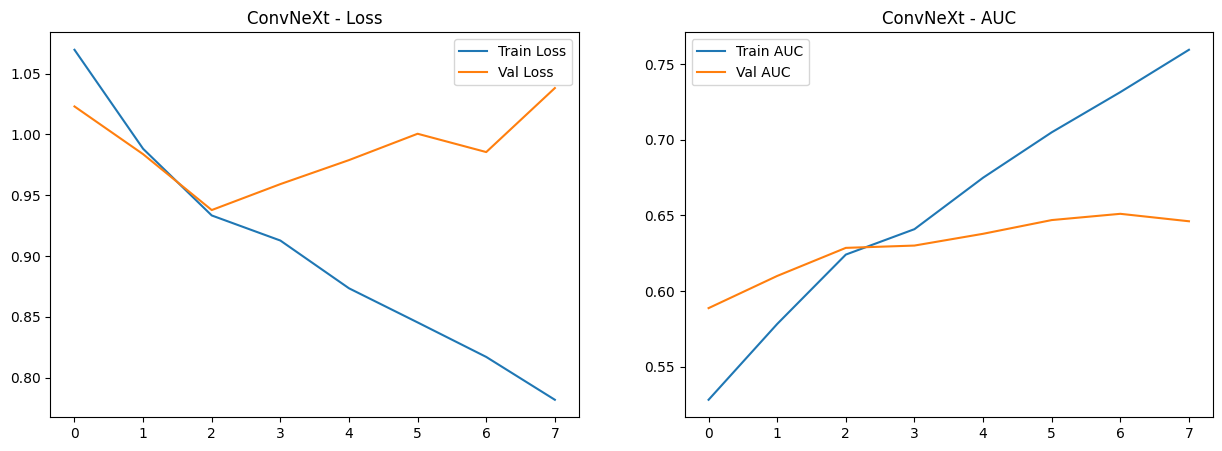

In [ ]:
# 2. Обучаем ConvNeXt

def train_ConvNeXt(train_loader, val_loader, device, num_epochs=15):
    """
    Обучение модели ConvNeXt с оптимизированными параметрами
    Возвращает обученную модель и историю метрик
    """
    # Инициализация модели
    model = SiameseConvNeXt(freeze=True).to(device)

    # Оптимизатор с настроенными параметрами
    optimizer = AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=3e-5,  # Уменьшенный learning rate
        weight_decay=0.05  # L2-регуляризация
    )

    # Scheduler для динамического изменения LR
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',  # Следим за ростом AUC
        factor=0.5,
        patience=2
    )

    # Функция потерь с учетом дисбаланса классов
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
    early_stopping = EarlyStopping(patience=5)
    history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

    for epoch in range(num_epochs):
        # Разморозка слоев после 3 эпох
        if epoch == 3:
            model.unfreeze_layers()
            print("Разморожены последние блоки ConvNeXt")

        # Обучение
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []
        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * img1.size(0)
            train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Валидация
        val_loss, val_preds, val_targets = 0.0, [], []
        model.eval()
        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * img1.size(0)
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Расчет метрик
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        train_auc = roc_auc_score(train_targets, train_preds)
        val_auc = roc_auc_score(val_targets, val_preds)

        # Обновление истории
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        # Логирование
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        # Scheduler и Early Stopping
        scheduler.step(val_auc)
        early_stopping(val_loss, val_auc)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

        # Очистка памяти
        torch.cuda.empty_cache()

    return model, history


print("\n=== Training ConvNeXt ===")
convnext_model, convnext_history = train_ConvNeXt(train_loader, val_loader, device)
plot_history(convnext_history, "ConvNeXt")

ConvNeXt демонстрирует умеренное переобучение, но с положительной динамикой.  

## Модель 4: Swin Transformer

In [ ]:
class SiameseSwin(nn.Module):
    def __init__(self, fc_size=512, dropout=0.5):
        super().__init__()
        # 1. Базовый трансформер
        self.base_model = AutoModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

        # 2. Закрепление весов (размораживаем последние 2 слоя)
        for name, param in self.base_model.named_parameters():
            if not any(layer in name for layer in ['layers.3', 'layers.2']):
                param.requires_grad = False

        # 3. Улучшенный классификатор
        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, fc_size),
            nn.LayerNorm(fc_size),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(fc_size, fc_size // 2),
            nn.LayerNorm(fc_size // 2),
            nn.GELU(),
            nn.Dropout(dropout * 0.8),

            nn.Linear(fc_size // 2, fc_size // 4),
            nn.GELU(),
            nn.Linear(fc_size // 4, 1)
        )

        # 4. Инициализация весов
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def unfreeze_layers(self, epoch):
        """Постепенное размораживание"""
        if epoch == 3:
            for name, param in self.base_model.named_parameters():
                if 'layers.1' in name:
                    param.requires_grad = True
            print("Разморожен блок layers.1")
        elif epoch == 5:
            for name, param in self.base_model.named_parameters():
                if 'layers.0' in name:
                    param.requires_grad = True
            print("Разморожен блок layers.0")

    def forward(self, img1, img2):
        img1 = (img1 - 0.5) * 2.0  # Нормализация [-1, 1]
        img2 = (img2 - 0.5) * 2.0

        feat1 = self.base_model(pixel_values=img1).last_hidden_state.mean(dim=1)
        feat2 = self.base_model(pixel_values=img2).last_hidden_state.mean(dim=1)

        x = torch.cat([feat1, feat2], dim=1)
        return self.classifier(x).squeeze(1)

In [ ]:
def train_swin(train_loader, val_loader, device, num_epochs=12):
    """Функция обучения"""
    model = SiameseSwin().to(device)

    # Оптимизатор с LAMB
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=3e-5,
        weight_decay=0.03,
        betas=(0.9, 0.999)
    )

    # Scheduler с линейным прогревом
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-5,
        total_steps=num_epochs * len(train_loader),
        pct_start=0.1,
        anneal_strategy='linear'
    )

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
    early_stopping = EarlyStopping(patience=4)
    history = {'train_loss': [], 'val_loss': [], 'train_auc': [], 'val_auc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_preds, train_targets = 0.0, [], []

        # Разморозка слоёв
        model.unfreeze_layers(epoch)

        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs).detach().cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        # Валидация
        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []
        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                outputs = model(img1, img2)
                val_loss += criterion(outputs, labels).item()
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Расчет метрик
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_auc = roc_auc_score(train_targets, train_preds)
        val_auc = roc_auc_score(val_targets, val_preds)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_auc'].append(train_auc)
        history['val_auc'].append(val_auc)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        if early_stopping(val_loss, val_auc):
            print("\nEarly stopping triggered")
            break

    return model, history


=== Training Swin Transformer ===

Epoch 1/12
Train Loss: 6.7973 | Val Loss: 2.4563
Train AUC: 0.5108 | Val AUC: 0.4947
LR: 4.21e-05

Epoch 2/12
Train Loss: 3.3578 | Val Loss: 0.9527
Train AUC: 0.4984 | Val AUC: 0.5285
LR: 4.63e-05

Epoch 3/12
Train Loss: 2.4306 | Val Loss: 0.9092
Train AUC: 0.4969 | Val AUC: 0.5484
LR: 4.17e-05
Разморожен блок layers.1

Epoch 4/12
Train Loss: 2.0164 | Val Loss: 0.9117
Train AUC: 0.5123 | Val AUC: 0.5454
LR: 3.70e-05

Epoch 5/12
Train Loss: 1.8044 | Val Loss: 0.8997
Train AUC: 0.5013 | Val AUC: 0.5507
LR: 3.24e-05
Разморожен блок layers.0

Epoch 6/12
Train Loss: 1.6351 | Val Loss: 0.9120
Train AUC: 0.5123 | Val AUC: 0.5594
LR: 2.78e-05

Epoch 7/12
Train Loss: 1.5354 | Val Loss: 0.9008
Train AUC: 0.5077 | Val AUC: 0.5581
LR: 2.31e-05

Epoch 8/12
Train Loss: 1.4836 | Val Loss: 0.9538
Train AUC: 0.5011 | Val AUC: 0.5565
LR: 1.85e-05

Epoch 9/12
Train Loss: 1.3982 | Val Loss: 0.9199
Train AUC: 0.5127 | Val AUC: 0.5592
LR: 1.39e-05

Epoch 10/12
Train Loss:

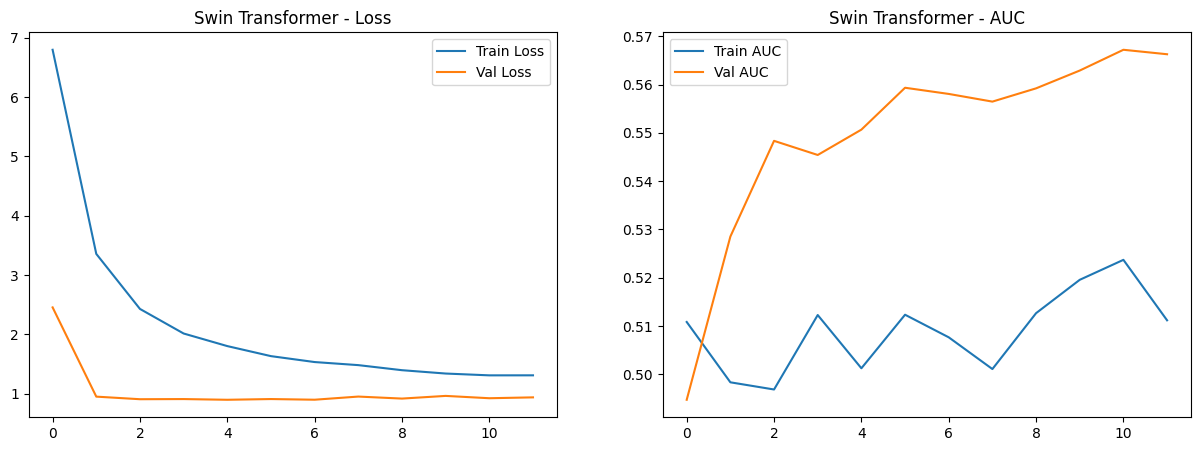

In [ ]:
# 2. Обучаем Swin Transformer
print("\n=== Training Swin Transformer ===")
swin_model, swin_history = train_swin(train_loader, val_loader, device)
plot_history(swin_history, "Swin Transformer")

Модель Swin Transformer демонстрирует проблемы со сходимостью, потенциал для улучшения еще есть

# Стекинг

In [ ]:
models = {
    'handmade': final_hand_model,
    'resnet': model,
    'convnext': convnext_model,
    'swin': swin_model
}


In [ ]:
def get_predictions(model, loader):
    """
    Получает предсказания модели на DataLoader.
    Возвращает вероятности (после sigmoid) в виде numpy-массива.
    """
    model.eval()
    preds = []
    with torch.no_grad():
        for img1, img2, _ in loader:
            img1, img2 = img1.to(device), img2.to(device)
            outputs = model(img1, img2)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds.extend(probs)
    return np.array(preds)

In [ ]:
def custom_metric(y_true, probs, threshold):
    """Кастомная метрика (50% AUC + 50% F1)"""
    preds = (probs > threshold).astype(int)
    return 0.2 * roc_auc_score(y_true, probs) + 0.8 * f1_score(y_true, preds)

In [ ]:
def stacking(models_dict, val_loader, test_loader, y_val):
    """Упрощённый стекинг: используем предобученные модели"""
    # 1. Получаем предсказания на валидации
    val_preds = {}
    for name, model in models_dict.items():
        model.eval()
        val_preds[name] = get_predictions(model, val_loader)

    X_meta_train = np.column_stack(list(val_preds.values()))

    # 2. Обучаем мета-модель
    meta_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    meta_model.fit(X_meta_train, y_val)

    # 3. Подбор порога
    val_meta_probs = meta_model.predict_proba(X_meta_train)[:, 1]
    thresholds = np.linspace(0.3, 0.7, 101)
    best_metric = -1
    best_thresh = 0.5
    for thresh in thresholds:
        metric = custom_metric(y_val, val_meta_probs, thresh)
        if metric > best_metric:
            best_metric = metric
            best_thresh = thresh
    print(f"Оптимальный порог: {best_thresh:.3f} | Метрика: {best_metric:.4f}")

    # 4. Тест
    test_preds = {}
    for name, model in models_dict.items():
        test_preds[name] = get_predictions(model, test_loader)
    X_meta_test = np.column_stack(list(test_preds.values()))
    test_meta_probs = meta_model.predict_proba(X_meta_test)[:, 1]
    final_predictions = (test_meta_probs > best_thresh).astype(int)

    return final_predictions, test_meta_probs, best_thresh

## Инференс стекинга

In [ ]:
final_preds, test_probs, threshold = stacking(
    models_dict=models,
    val_loader=val_loader,
    test_loader=test_loader,
    y_val=val_holdout['is_image1_better'].values
)

Оптимальный порог: 0.416 | Метрика: 0.8594


In [ ]:
pd.DataFrame({
    'index': range(len(final_preds)),
    'prediction': final_preds}).to_csv('submission_stecking.csv', index=False)
print("✅ Предсказания сохранены в 'submission_stecking.csv' ")

✅ Предсказания сохранены в 'submission_stecking.csv' 


Результат на лидерборде: 0.57666

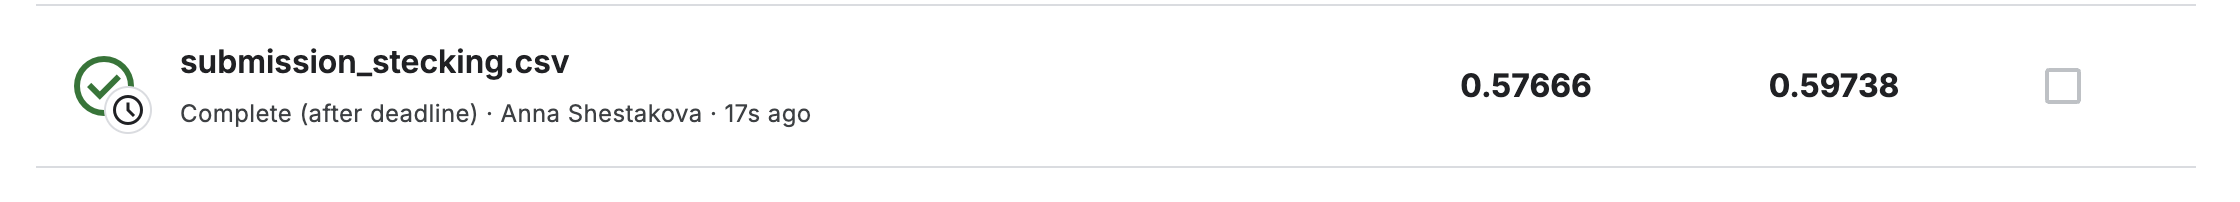

# Ансамбль с весами + подбор весов

In [ ]:
def find_optimal_weights(val_preds_dict, y_val, threshold=0.5):
    """
    Подбирает оптимальные веса для ансамбля, максимизируя custom_metric.

    Параметры:
        val_preds_dict: dict {'model_name': val_probs}
        y_val: истинные метки (np.array)
        threshold: порог для бинаризации

    Возвращает:
        optimal_weights: нормализованные веса (softmax)
    """
    preds_matrix = np.column_stack(list(val_preds_dict.values()))  # (N_samples, N_models)

    def objective(weights):
        # Преобразуем веса через softmax для нормализации
        w = np.exp(weights)
        w_normalized = w / w.sum()

        # Взвешенное среднее
        weighted_probs = preds_matrix @ w_normalized

        # Минимизируем минус метрики (т.е. максимизируем метрику)
        score = -custom_metric(y_val, weighted_probs, threshold=threshold)
        return score

    # Начальные веса (равные)
    initial_weights = np.zeros(len(val_preds_dict))

    # Оптимизация
    result = minimize(
        objective,
        initial_weights,
        method='L-BFGS-B',
        options={'maxiter': 100, 'disp': False}
    )

    # Извлекаем и нормализуем финальные веса
    w = np.exp(result.x)
    optimal_weights = w / w.sum()

    return optimal_weights

In [ ]:
# Ансамбль с весами
def weighted_ensemble(models_dict, weights, test_loader, threshold=0.5):
    """
    Делает предсказания ансамблем с заданными весами.

    Возвращает:
        final_preds: бинарные предсказания (0/1)
        weighted_probs: сырые вероятности ансамбля
    """
    test_preds = []
    model_names = list(models_dict.keys())

    for i, (name, model) in enumerate(models_dict.items()):
        print(f"Получение предсказаний для модели: {name}...")
        probs = get_predictions(model, test_loader)
        test_preds.append(probs * weights[i])

    weighted_probs = np.sum(test_preds, axis=0)
    final_preds = (weighted_probs > threshold).astype(int)

    return final_preds, weighted_probs

In [ ]:
# Выполнение ансамбля

# Получаем предсказания на валидации
print("Получение OOF-предсказаний на валидации...")
val_preds = {}
for name, model in models.items():
    val_preds[name] = get_predictions(model, val_loader)

# Подбираем оптимальные веса
print("Подбор оптимальных весов ансамбля...")
optimal_weights = find_optimal_weights(
    val_preds_dict=val_preds,
    y_val=val_holdout['is_image1_better'].values,
    threshold=0.5
)

# Вывод весов
print(f"Оптимальные веса ансамбля:")
for name, weight in zip(val_preds.keys(), optimal_weights):
    print(f"  {name}: {weight:.3f}")

Получение OOF-предсказаний на валидации...
Подбор оптимальных весов ансамбля...
Оптимальные веса ансамбля:
  handmade: 0.250
  resnet: 0.250
  convnext: 0.250
  swin: 0.250


In [ ]:
# Применяем ансамбль на тесте
print("Запуск ансамбля на тестовых данных...")
final_ensemble_preds, ensemble_probs = weighted_ensemble(
    models_dict=models,
    weights=optimal_weights,
    test_loader=test_loader,
    threshold=0.5
)

print("✅ Ансамбль завершён.")

Запуск ансамбля на тестовых данных...
Получение предсказаний для модели: handmade...
Получение предсказаний для модели: resnet...
Получение предсказаний для модели: convnext...
Получение предсказаний для модели: swin...
✅ Ансамбль завершён.


## Инференс ансамбля

In [ ]:
final_predictions = (test_probs > threshold).astype(int)

pd.DataFrame({
    'index': range(len(final_ensemble_preds)),
    'prediction': final_ensemble_preds}).to_csv('submission_ensemble.csv', index=False)

print("✅ Предсказания сохранены в 'submission_ensemble.csv' ")

✅ Предсказания сохранены в 'submission_ensemble.csv' 


Результат на лидерборде  0.62993

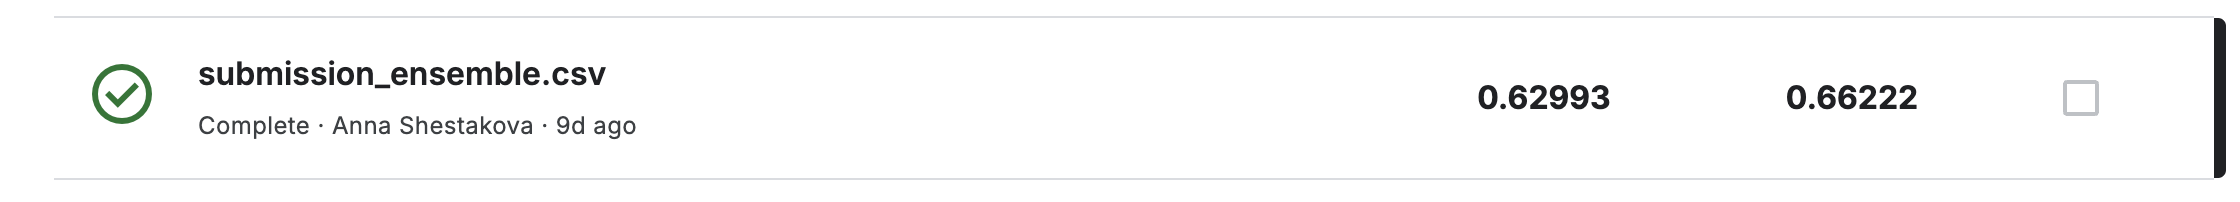